In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#connects to google drive to recieve zipped file

Mounted at /content/drive


In [3]:
import zipfile
import os

# defining path for image
zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/flowers"

#extracting the zip file
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("The folder already exists.")

In [4]:
dataset_path = "/content/flowers/flowers"
print("Classes found:", os.listdir(dataset_path))
#checking structure of unzipped file archive(1)-->flowers-->classes

Classes found: ['tulip', 'rose', 'dandelion', 'daisy', 'sunflower']


In [5]:
IMG_SIZE = 128
data = []
labels = []

dataset_path = "/content/flowers/flowers"
classes = sorted(os.listdir(dataset_path))

#open all images check if its not empty resize and push into data[] with labels
for flower in classes:
    folder = os.path.join(dataset_path, flower)
    image_files = glob(os.path.join(folder, "*.jpg"))
    for img_file in image_files:
        img = cv2.imread(img_file)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(flower)

#arranges as (number of files,128,128(size),3(rgb))
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [6]:
# Normalize pixel values to [0, 1]
data = data / 255.0

# One-hot encode labels help identify type of flower [0,0,0,1,0]
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

class_names = lb.classes_

# Split data into 80:20 training and validation using random seed
X_train, X_val, y_train, y_val = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels
)

print(f"✅Data split:{X_train.shape[0]} training, {X_val.shape[0]} validation")


✅Data split:3447 training, 862 validation


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# basic dense model flatten hidden layers follow a basic linear regression model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.2818 - loss: 9.2978 - val_accuracy: 0.3979 - val_loss: 2.0685
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.4046 - loss: 1.8446 - val_accuracy: 0.3492 - val_loss: 2.2221
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.4471 - loss: 1.5025 - val_accuracy: 0.4327 - val_loss: 1.3874
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.4963 - loss: 1.3115 - val_accuracy: 0.3469 - val_loss: 1.6557
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.5057 - loss: 1.2369 - val_accuracy: 0.4374 - val_loss: 1.3603
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.5174 - loss: 1.2076 - val_accuracy: 0.4246 - val_loss: 1.4879
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.5737 - loss: 1.0610 - val_accuracy: 0.4478 - val_loss: 1.3716
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.6189 - loss: 0

In [8]:
#predicting validation images based on the computed scale
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# original one hot encoded index values
y_true = np.argmax(y_val, axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


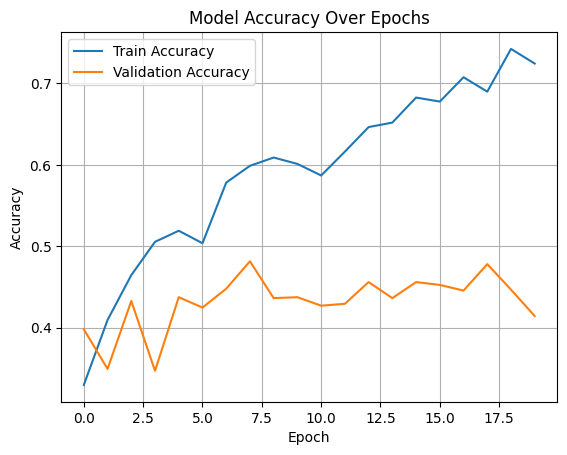

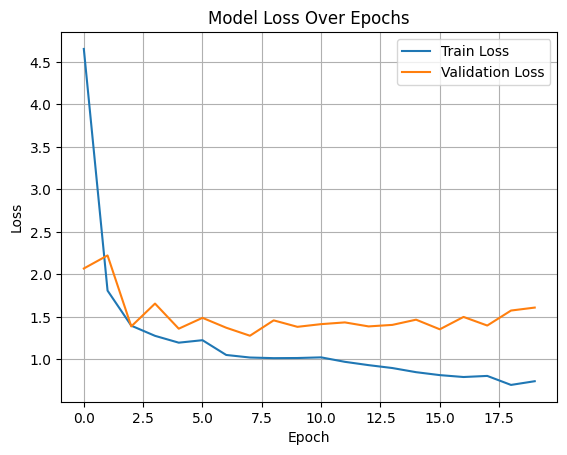

In [9]:
import matplotlib.pyplot as plt

#Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


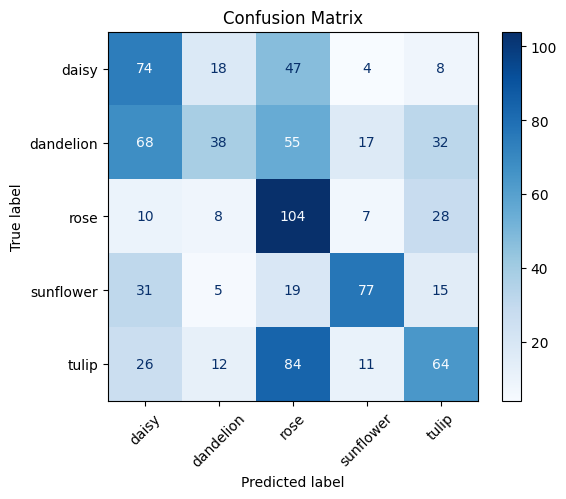

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# one-hot encoded to numbers
y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(model.predict(X_val), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [11]:
model.save("dense_flower_model.h5")
print("✅ Model saved as dense_flower_model.h5")


✅ Model saved as dense_flower_model.h5


In [ ]:

from google.colab import files
files.download("dense_flower_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
#from tensorflow.keras.models import load_model
#model = load_model("dense_flower_model.h5")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#convolution model with 3 convolution layers and increasing filters
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(5, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
import os
import cv2
from glob import glob

#loading images again(technical issue)
dataset_path = "/content/flowers"  
classes = sorted(os.listdir(dataset_path))

images = []
labels = []

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for img_path in glob(os.path.join(class_dir, "*.jpg")):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        if img is not None:
            images.append(img)
            labels.append(class_name)



In [22]:
dataset_path = "/content/flowers/flowers"


In [ ]:
import os
import cv2
from glob import glob

dataset_path = "/content/flowers/flowers"  
classes = sorted(os.listdir(dataset_path))

images = []
labels = []

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    print(f"Reading from: {class_dir}")
    for img_path in glob(os.path.join(class_dir, "*.jpg")):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(class_name)

print(f"✅ Loaded {len(images)} images")


Reading from: /content/flowers/flowers/daisy
Reading from: /content/flowers/flowers/dandelion
Reading from: /content/flowers/flowers/rose
Reading from: /content/flowers/flowers/sunflower
Reading from: /content/flowers/flowers/tulip
✅ Loaded 4309 images


In [ ]:
#normalizing image dataset
from sklearn.preprocessing import LabelBinarizer
import numpy as np

lb = LabelBinarizer()
y = lb.fit_transform(labels)

X = np.array(images) / 255.0


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data has no augmentation(similar to real life)
val_datagen = ImageDataGenerator()

# Wrap training data in the pipeline
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

# Validation generator
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)


In [27]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3105 - loss: 1.5144 - val_accuracy: 0.5360 - val_loss: 1.1244
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5505 - loss: 1.1089 - val_accuracy: 0.6009 - val_loss: 1.0180
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6013 - loss: 0.9928 - val_accuracy: 0.6357 - val_loss: 0.9186
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6541 - loss: 0.8798 - val_accuracy: 0.6682 - val_loss: 0.8678
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6766 - loss: 0.8578 - val_accuracy: 0.6833 - val_loss: 0.8189
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6838 - loss: 0.8072 - val_accuracy: 0.6891 - val_loss: 0.7958
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7032 - loss: 0.7788 - val_accuracy: 0.6879 - val_loss: 0.8149
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7036 - loss: 0.7751 - val_accu

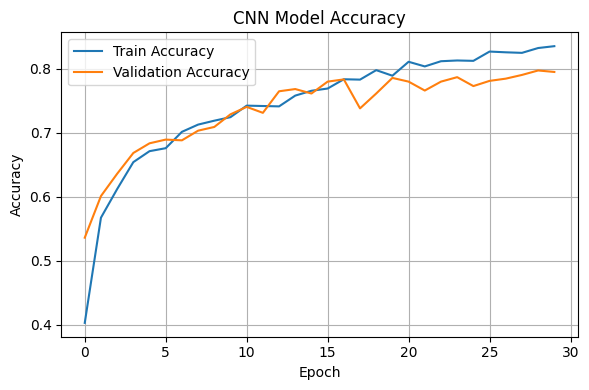

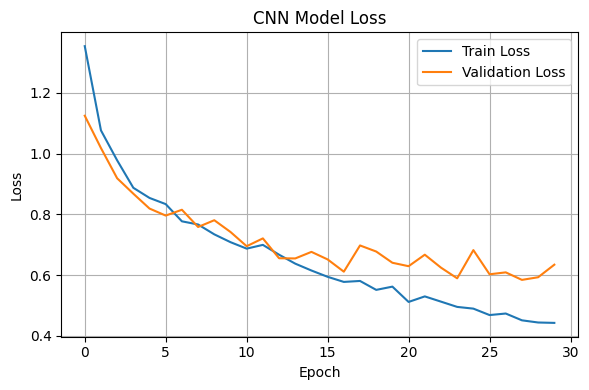

In [28]:
import matplotlib.pyplot as plt

# 📈 Accuracy
plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Loss
plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step


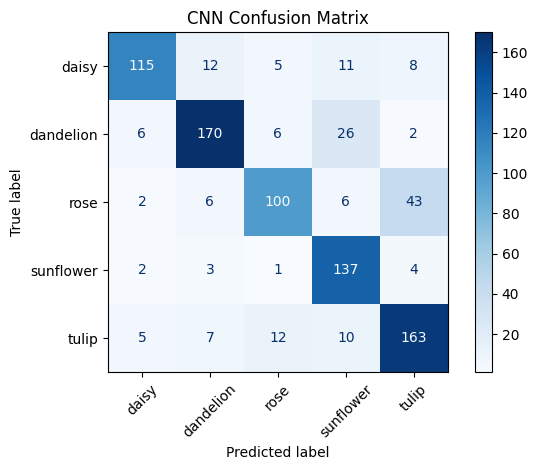

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = cnn_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_names = lb.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [30]:
cnn_model.save("cnn_flower_model.h5")


In [31]:
from google.colab import files
files.download("cnn_flower_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
#from tensorflow.keras.models import load_model

#cnn_model = load_model("cnn_flower_model.h5")
